# Low Energy Nuclear (LENR) Cycles Model (Fixed)
This notebook tests whether a minimal, topology-first model can simulate and falsify a low-energy nuclear reaction (LENR) cycle driven by breath-like EM coherence.

## 1. Setup & Configuration

In [1]:
# @title 1.1 Config — Toggles & Seeds

# CONFIG
USE_STAR   = True          # S1 only if False; S1..S4 if True
USE_PADIC  = False
USE_QUAT   = True          # optional: quaternion state
RNG_SEED   = 13

import random
import numpy as np

random.seed(RNG_SEED)
np.random.seed(RNG_SEED)

In [2]:
# @title 1.2 Imports

import numpy as np
import networkx as nx
from mpmath import mpf, power
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.sparse import csr_matrix

%matplotlib inline

## 2. Geometry & Topology

In [3]:
# @title 2.1 Geometry — S1..S4 shells with role policy

ROLE_BY_MOD = {0: "Compression", 1: "Expression", 2: "Stabilisation", 3: "Emission"}

def build_geometry(use_star: bool = True):
    """Builds the STAR graph geometry before policy enforcement."""
    G = nx.DiGraph()
    nodes = ['C', 'S'] + [str(i) for i in range(16)]
    G.add_nodes_from(nodes)
    
    roles = {n: ('Mediator' if n == 'C' else 'Sink' if n == 'S' else ROLE_BY_MOD[int(n) % 4]) for n in G.nodes()}
    shells = {n: (f"S{1 + int(int(n) / 4)}" if n.isdigit() else '*') for n in G.nodes()}
    
    # Add intra-shell edges for all 4 shells
    for i in range(4):
        b = i * 4
        s = [str(b + j) for j in range(4)]
        G.add_edge('C', s[1], kind='activation')
        G.add_edge(s[1], s[2], kind='work')
        G.add_edge(s[2], 'C', kind='squeeze')
        G.add_edge('C', s[3], kind='fusion')
        G.add_edge(s[3], s[0], kind='heat')
        G.add_edge(s[0], 'C', kind='reset')

    # Add inter-shell (cubic) and sink edges
    for a, b in [(0, 4), (8, 12)]: G.add_edge(str(a), str(b), kind='compression'); G.add_edge(str(b), str(a), kind='compression')
    for a, b in [(3, 6), (11, 14)]: G.add_edge(str(a), str(b), kind='work_bridge')
    for e_node in [3, 7, 11, 15]: G.add_edge(str(e_node), 'C', kind='heat_bridge')
    for e_node in [3, 7, 11, 15]: G.add_edge(str(e_node), 'S', kind='sink')
    
    # Define the connection policy
    policy = {
        'Compression': {'out': {'Mediator', 'Compression'}, 'in': {'Emission', 'Compression', 'Mediator'}},
        'Expression': {'out': {'Stabilisation', 'Mediator'}, 'in': {'Mediator'}},
        'Stabilisation': {'out': {'Mediator'}, 'in': {'Expression', 'Emission'}},
        'Emission': {'out': {'Compression', 'Stabilisation', 'Mediator', 'Sink'}, 'in': {'Stabilisation', 'Mediator'}},
        'Mediator': {'out': {'Expression', 'Emission', 'Compression', 'Stabilisation', 'Mediator', 'Sink'}, 'in': {'*'}},
        'Sink': {'in': {'*'}} 
    }
    return G, roles, shells, policy

def enforce_policy(G, roles, policy):
    """Filters the graph, keeping only edges that conform to the policy."""
    keep = []
    for u, v, data in G.edges(data=True):
        ru, rv = roles.get(u, 'Mediator'), roles.get(v, 'Mediator')
        allowed_out = policy.get(ru, {}).get('out', set())
        allowed_in = policy.get(rv, {}).get('in', set())
        if ('*' in allowed_in or ru in allowed_in) and (rv in allowed_out):
            keep.append((u, v, data))
    
    H = nx.DiGraph()
    H.add_nodes_from(G.nodes())
    H.add_edges_from(keep)
    return H

# Build and enforce
G_raw, roles, shells, policy = build_geometry(USE_STAR)
G0 = enforce_policy(G_raw, roles, policy)
nx.set_node_attributes(G0, roles, 'role')
nx.set_node_attributes(G0, shells, 'shell')
G0.graph.update({'roles': roles, 'shells': shells, 'policy': policy})

print(f"Raw graph edges: {G_raw.number_of_edges()}")
print(f"Policy-enforced graph: |V|={G0.number_of_nodes()} |E|={G0.number_of_edges()}")

Raw graph edges: 38
Policy-enforced graph: |V|=18 |E|=38


In [4]:
# @title 2.2 DEC Backbone — ∂ Operators & Diagonal Hodge Stars

def build_dec_backbone(G):
    """Builds the DEC backbone to match the provided graph G."""
    # Sort nodes for consistent ordering, handling non-digit nodes
    V = sorted(list(G.nodes()), key=lambda x: (not x.isdigit(), int(x) if x.isdigit() else float('inf'), x))
    node_id = {v: i for i, v in enumerate(V)}
    
    # Generate faces for all shells from the graph's shell structure
    F = []
    shells = nx.get_node_attributes(G, 'shell')
    shell_nodes = defaultdict(list)
    for node, shell in shells.items():
        if shell.startswith('S'):
            shell_nodes[shell].append(node)
    
    for shell, nodes in shell_nodes.items():
        # Outer faces of the tetrahedron
        F.extend([(nodes[0],nodes[1],nodes[2]), (nodes[0],nodes[1],nodes[3]), (nodes[0],nodes[2],nodes[3]), (nodes[1],nodes[2],nodes[3])])
        # Centroid-facing faces
        if 'C' in V:
            F.extend([(nodes[0],nodes[1],'C'), (nodes[0],nodes[2],'C'), (nodes[0],nodes[3],'C'), (nodes[1],nodes[2],'C'), (nodes[1],nodes[3],'C'), (nodes[2],nodes[3],'C')])
    
    # Edges are derived from the faces to form the simplicial complex
    edges_backbone = sorted({tuple(sorted((a, b))) for a, b, c in F for a, b in [(a, b), (b, c), (c, a)]})
    edge_id = {e: i for i, e in enumerate(edges_backbone)}
    face_id = {f: i for i, f in enumerate(F)}
    
    # Boundary Maps
    B1 = np.zeros((len(V), len(edges_backbone)), dtype=float)
    for (u,v), ei in edge_id.items():
        if u in node_id and v in node_id:
            B1[node_id[u], ei] = -1.0
            B1[node_id[v], ei] = 1.0
    B1 = csr_matrix(B1)
    
    B2 = np.zeros((len(edges_backbone), len(F)), dtype=float)
    for fj, (v0, v1, v2) in enumerate(F):
        for a, b in [(v0, v1), (v1, v2), (v2, v0)]:
            e = tuple(sorted((a,b)))
            sign = 1.0 if (a,b) == e else -1.0
            if e in edge_id:
                B2[edge_id[e], fj] += sign
    B2 = csr_matrix(B2)
    
    # Diagonal Hodge Stars
    L = 1.0
    len_e = np.full(len(edge_id), L, dtype=float)
    area_f = np.full(len(F), (np.sqrt(3)/4.0)*L*L, dtype=float)
    dual_e = np.full(len(edge_id), (L*L)/4.0, dtype=float)
    dual_f = np.full(len(F), (L/3.0), dtype=float)
    Star1 = csr_matrix(np.diag(dual_e / len_e))
    Star2 = csr_matrix(np.diag(dual_f / area_f))
    
    # Audits
    inf_norm = np.max(np.abs(B1 @ B2)) if (B1 @ B2).nnz > 0 else 0.0
    print(f"[DEC Dims] |V|={len(V)} |E|={len(edge_id)} |F|={len(F)}")
    print(f"||B1·B2||_∞ = {inf_norm:.3e} (expect 0)")
    print(f"Star1/2 SPD? {np.all(Star1.diagonal() > 0)} / {np.all(Star2.diagonal() > 0)}")
    
    return V, F, node_id, edge_id, face_id, B1, B2, Star1, Star2

V, F, node_id, edge_id, face_id, B1, B2, Star1, Star2 = build_dec_backbone(G0)

[DEC Dims] |V|=18 |E|=40 |F|=40
||B1·B2||_∞ = 0.000e+00 (expect 0)
Star1/2 SPD? True / True


## 3. Markov Layer & Simulation Engine

In [5]:
# @title 3.1 Markov Layer & Breath Modulation

def build_markov(G):
    """Adds 'rate' and 'kind' attributes to graph edges based on a base dictionary."""
    base = {
        'activation': 0.5, 'work': 0.8, 'squeeze': 0.9, 'fusion': 0.7,
        'heat': 1.0, 'reset': 0.3, 'compression': 0.3,
        'work_bridge': 0.4, 'heat_bridge': 0.5, 'sink': 0.2
    }
    rates = {e: base.get(d.get('kind', 'work'), 0.5) for e, d in G.edges.items()}
    kinds = {e: d.get('kind', 'work') for e, d in G.edges.items()}
    nx.set_edge_attributes(G, rates, 'rate')
    nx.set_edge_attributes(G, kinds, 'kind')
    return rates, kinds

EDGE_RATES, EDGE_KINDS = build_markov(G0)

def apply_breath(G_base, step, inhale_gain=1.15, exhale_gain=1.10):
    """Applies breath-like modulation to edge rates."""
    phase = 'in' if (step % 2) == 0 else 'out'
    G = G_base.copy()
    roles = G.graph['roles']
    sinks = {n for n, r in roles.items() if r == 'Compression'}
    sources = {'C'}
    pumps = {n for n, r in roles.items() if r in {'Expression', 'Emission'}}
    for u, v, data in G.edges(data=True):
        rate = data['rate'] # Start with the base rate
        if phase == 'in' and (v in sinks or v in sources): rate *= inhale_gain
        elif phase == 'out' and (u in sources and v in pumps): rate *= exhale_gain
        data['rate'] = rate # Update the rate for the current step
    return G, phase

print(f"Markov layer: {len(EDGE_RATES)} edges across kinds {sorted(set(EDGE_KINDS.values()))}")

Markov layer: 38 edges across kinds ['activation', 'compression', 'fusion', 'heat', 'heat_bridge', 'reset', 'sink', 'squeeze', 'work', 'work_bridge']


In [6]:
# @title 3.2 Quaternion State & Coupling (Optional)

def init_quaternion_state(G, roles):
    Q = {n: np.zeros(4) for n in G.nodes()}
    for n, r in roles.items():
        if r == 'Compression': Q[n] = np.array([1.0, 0.0, 0.2, 0.0])
        elif r == 'Expression': Q[n] = np.array([0.1, 1.0, 0.0, 0.0])
        elif r == 'Stabilisation': Q[n] = np.array([0.0, 0.0, 1.0, 0.1])
        elif r == 'Emission': Q[n] = np.array([0.0, 0.1, 0.0, 1.0])
    return Q

def project(flow_kind, vec):
    arr = np.asarray(vec, dtype=float)
    if flow_kind in ('work', 'activation'): return float(arr[1])
    if flow_kind in ('squeeze', 'reset'): return float(arr[0] + arr[2])
    if flow_kind in ('fusion', 'work_bridge'): return float(arr[3] + arr[1])
    if flow_kind in ('heat', 'heat_bridge'): return float(arr[3])
    if flow_kind == 'compression': return float(arr[0])
    if flow_kind == 'sink': return float(arr.sum())
    return 0.0

QUAT_STATE = init_quaternion_state(G0, roles) if USE_QUAT else {}

def _edge_sign_index(u, v, edge_id):
    e_sorted = tuple(sorted((u,v)))
    if e_sorted in edge_id:
        sign = 1.0 if (u,v) == e_sorted else -1.0
        return sign, edge_id[e_sorted]
    return 0.0, None

def markov_to_currents(Gk, edge_id, coherence_gain=0.1, state=None):
    J = np.zeros(len(edge_id), dtype=float)
    active_kinds = set(EDGE_KINDS.values()) - {'heat', 'heat_bridge', 'sink'}
    state = QUAT_STATE if state is None and USE_QUAT else state
    for u, v, data in Gk.edges(data=True):
        kind, rate = data.get('kind'), data.get('rate', 0.0)
        if kind not in active_kinds or rate <= 0.0: continue
        sgn, ei = _edge_sign_index(u, v, edge_id)
        if ei is None: continue
        amp = project(kind, state.get(u, np.zeros(4))) if state else 1.0
        J[ei] += sgn * coherence_gain * rate * amp
    return J

def accumulate_heat(Gk, dt):
    heat_kinds = {'heat', 'heat_bridge', 'sink'}
    return sum(d.get('rate', 0.0) * dt for u, v, d in Gk.edges(data=True) if d.get('kind') in heat_kinds)

if USE_QUAT: print("Quaternion state initialised.")

Quaternion state initialised.


In [7]:
# @title 3.3 Phase Linter

def build_phase_linter(G, S1_nodes, S2_nodes):
    """Builds and returns the linter function."""
    node_list = sorted(list(G.nodes()), key=lambda x: (not x.isdigit(), int(x) if x.isdigit() else x))
    idx = {k: i for i, k in enumerate(node_list)}
    n_nodes = len(node_list)
    kap = np.zeros((n_nodes, n_nodes))
    theta = np.zeros_like(kap)

    def _set_k(a, b, val): 
        if a in idx and b in idx: i, j = idx[a], idx[b]; kap[i,j]=val; kap[j,i]=val
    def _set_th(a, b, rad): 
        if a in idx and b in idx: i, j = idx[a], idx[b]; theta[i,j]=rad; theta[j,i]=-rad

    # Define couplings
    for U in (S1_nodes, S2_nodes):
        for i, u in enumerate(U): 
            for v in U[i+1:]: _set_k(u, v, 0.02)
    _set_k('1', '2', 0.12); _set_th('1', '2', np.pi/2)
    if USE_STAR:
        _set_k('5', '6', 0.12); _set_th('5', '6', np.pi/2)
        _set_k('3', '6', 0.08); _set_th('3', '6', np.pi/2)
        for p in [('7','4'), ('7','2'), ('5','0')]: _set_k(*p, 0.05); _set_th(*p, np.pi)

    gamma_C = 0.05
    phi_state = np.zeros(n_nodes)

    def linter_fn(step, dt=0.05, relax_steps=5):
        nonlocal phi_state
        for _ in range(relax_steps):
            d_phi = np.zeros_like(phi_state)
            for i, u in enumerate(node_list):
                if u == 'C': continue
                acc = sum(kap[i,j] * np.sin(phi_state[j] - phi_state[i] - theta[i,j]) for j in range(n_nodes) if i != j)
                if 'C' in idx: acc -= gamma_C * np.sin(phi_state[i] - phi_state[idx['C']])
                d_phi[i] = acc
            phi_state += dt * d_phi
            phi_state = (phi_state + np.pi) % (2 * np.pi) - np.pi
        
        errors = []
        def err(a,b,trg): 
            if a in idx and b in idx: return np.degrees(np.abs(_wrap_pi((phi_state[idx[a]]-phi_state[idx[b]])-trg)))
            return np.nan
        errors.append(err('1','2',np.pi/2))
        if USE_STAR: errors.extend([err('5','6',np.pi/2), err('3','6',np.pi/2)])
        return np.nanmean([e for e in errors if np.isfinite(e)])

    def _wrap_pi(x): return (x + np.pi) % (2 * np.pi) - np.pi
    return linter_fn

linter_fn = build_phase_linter(G0, [str(i) for i in range(4)], [str(i) for i in range(4,8)])
print("Phase linter function 'linter_fn' created.")

Phase linter function 'linter_fn' created.


In [8]:
# @title 3.4 Core Engine — Leapfrog DEC Loop

def run_lenr_core(
    G_base, steps: int = 400, dt: float = 1e-3, coherence_gain: float = 0.1, 
    report_every: int = 20, state: dict = None):
    """Runs the main DEC simulation loop."""
    
    B2t = B2.T.toarray()
    inv_star1_diag = 1.0 / Star1.diagonal()
    
    E = np.zeros(B1.shape[1], dtype=float)
    B = np.zeros(B2.shape[1], dtype=float)
    
    # Initial condition: small pump on C->1 if it exists on the backbone
    s, C1_idx = _edge_sign_index('C', '1', edge_id)
    if C1_idx is not None: E[C1_idx] = 1e-4 * s
    
    Q_sink = 0.0
    U_prev = 0.5 * (E @ Star1 @ E + B @ Star2 @ B) # energy_field(E, B, Star1, Star2)
    
    hist = {k: [] for k in ["heat", "energy", "residual", "phase_error", "samples", "Rc_in", "Rc_out", "sink_throughput"]}
    hist['dt'] = dt
    
    def _centroid_reliance_local(Gk):
        total = sum(d.get('rate', 0.0) for u,v,d in Gk.edges(data=True))
        via_c = sum(d.get('rate', 0.0) for u,v,d in Gk.edges(data=True) if u == 'C' or v == 'C')
        return via_c / total if total > 0.0 else 0.0
    
    for n in range(steps):
        Gk, phase = apply_breath(G_base, n)
        J = markov_to_currents(Gk, edge_id, coherence_gain, state)
        
        # Leapfrog step
        B = B - dt * (B2t @ E)
        drive = B2 @ (Star2 @ B) - J
        E = E + dt * (drive * inv_star1_diag)
        
        # Accounting & Diagnostics
        current_heat = accumulate_heat(Gk, dt)
        Q_sink += current_heat
        U_now = 0.5 * (E @ Star1 @ E + B @ Star2 @ B)
        residual = (U_now + Q_sink) - U_prev
        U_prev = U_now + Q_sink
        
        if n % report_every == 0 or n == steps - 1:
            hist["heat"].append(Q_sink)
            hist["energy"].append(U_now)
            hist["residual"].append(residual)
            hist["samples"].append(n)
            hist["phase_error"].append(linter_fn(n))
            hist["sink_throughput"].append(current_heat / dt)
            rc = _centroid_reliance_local(Gk)
            hist[f"Rc_{phase}"].append(rc)
            
    return hist

print("Core engine 'run_lenr_core' defined.")

Core engine 'run_lenr_core' defined.


## 4. Simulation & Analysis

In [9]:
# @title 4.1 Run Simulation

hist = run_lenr_core(
    G0, 
    steps=1000, 
    dt=1e-3, 
    coherence_gain=0.25, 
    report_every=10, 
    state=QUAT_STATE
)

print("Simulation complete. History contains keys:", list(hist.keys()))

Simulation complete. History contains keys: ['heat', 'energy', 'residual', 'phase_error', 'samples', 'Rc_in', 'Rc_out', 'sink_throughput', 'dt']


In [10]:
# @title 4.2 Health Reporter

def detect_bursts_from_Q(samples, Q, jitter_frac=0.15, min_pos=8):
    s = np.asarray(samples, dtype=int)
    q = np.asarray(Q, dtype=float)
    if len(q) < 3: return dict(n=0, idx=[], unit=np.nan)
    dq = np.diff(q)
    pos = np.abs(dq[dq > 0])
    if len(pos) < min_pos: return dict(n=0, idx=[], unit=np.nan)
    unit = float(np.median(pos)); tol = jitter_frac * unit
    idxs = []
    for i, dqi in enumerate(dq):
        if dqi <= 0: continue
        k = round(dqi / unit) if unit > 0 else 0
        if k <= 0: continue
        if abs(dqi - k*unit) <= tol: idxs.append(i+1)
    return dict(n=len(idxs), idx=idxs, unit=unit)

print("=== Health Report ===")
print(f"|V|={len(G0.nodes())} |E|={len(G0.edges())}")
print(f"Residual max |Δ(U+Q)| = {np.max(np.abs(hist['residual'])):.3e}")

Rc_in  = np.mean(hist.get('Rc_in',[np.nan]))
Rc_out = np.mean(hist.get('Rc_out',[np.nan]))
print(f"Centroid reliance (mean): in={Rc_in:.3f} out={Rc_out:.3f}")

sink_rate = np.mean(hist.get('sink_throughput', [0.0]))
print(f"Sink throughput (mean rate): {sink_rate:.3f}")

print(f"Phase samples: {len(hist.get('phase_error',[]))}")
print(f"Phase error mean: {np.mean(hist.get('phase_error', [np.nan])):.3f} deg")

bd = detect_bursts_from_Q(hist['samples'], hist['heat'], jitter_frac=0.15)
print(f"Bursts: {bd['n']} | unit ≈ {bd.get('unit', np.nan):.3e} | idx (first 10): {bd.get('idx', [])[:10]}")

=== Health Report ===
|V|=18 |E|=38
Residual max |Δ(U+Q)| = 8.273e-03
Centroid reliance (mean): in=0.539 out=0.547
Sink throughput (mean rate): 7.691
Phase samples: 101
Phase error mean: 152.023 deg
Bursts: 100 | unit ≈ 7.250e-02 | idx (first 10): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


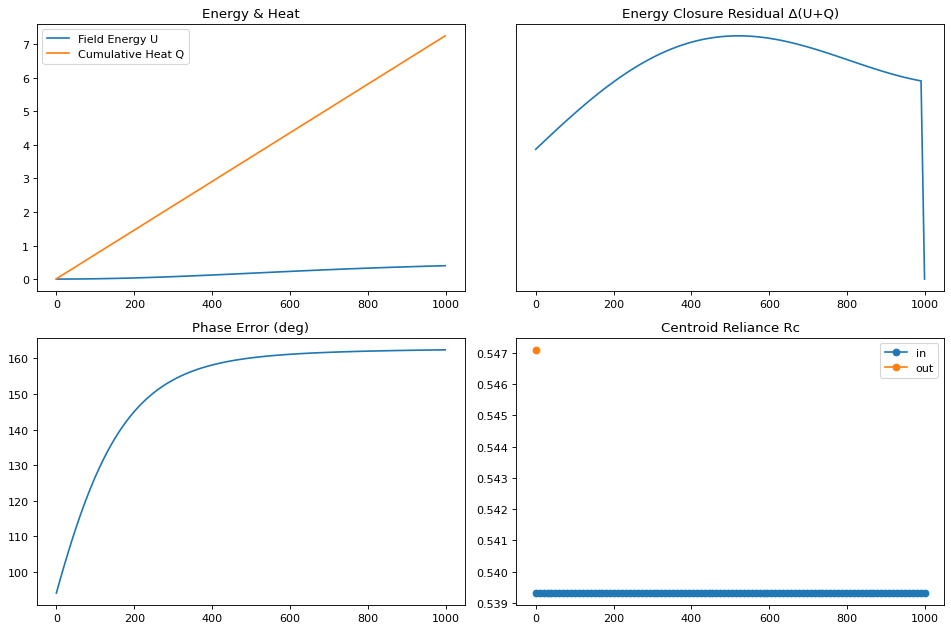

In [11]:
# @title 4.3 Visualizations

def plot_diagnostics(hist):
    s = hist.get("samples", [])
    fig, axs = plt.subplots(2, 2, figsize=(12, 8), dpi=80)
    
    # Energy & Heat
    axs[0,0].plot(s, hist.get("energy", []), label="Field Energy U")
    axs[0,0].plot(s, hist.get("heat", []), label="Cumulative Heat Q")
    axs[0,0].set_title("Energy & Heat")
    axs[0,0].legend()
    
    # Residual
    axs[0,1].plot(s, hist.get("residual", []))
    axs[0,1].set_title("Energy Closure Residual Δ(U+Q)")
    axs[0,1].set_yscale('symlog', linthresh=1e-12)
    
    # Phase Error
    axs[1,0].plot(s, hist.get("phase_error", []))
    axs[1,0].set_title("Phase Error (deg)")
    
    # Centroid Reliance
    rc_in_steps = np.linspace(s[0], s[-1], len(hist.get("Rc_in",[])))
    rc_out_steps = np.linspace(s[0], s[-1], len(hist.get("Rc_out",[])))
    axs[1,1].plot(rc_in_steps, hist.get("Rc_in",[]), 'o-', label='in')
    axs[1,1].plot(rc_out_steps, hist.get("Rc_out",[]), 'o-', label='out')
    axs[1,1].set_title("Centroid Reliance Rc")
    axs[1,1].legend()
    
    plt.tight_layout()
    plt.show()

plot_diagnostics(hist)